In [1]:
import pandas as pd
import polars as pl
from sklearn.metrics import average_precision_score
import seaborn as sns
import matplotlib.pyplot as plt
from tqdm import tqdm

In [ ]:
TODO: use the precomputed results from rule get_metric
and make the subset be a function of dataset
so all results loaded as once
also the score should be a function of the dataset
e.g. get l2 dist etc.
similar to performance.ipynb
and rename this notebook as performance_all.ipynb

In [2]:
model_metadata = pd.read_csv("../../config/models.csv")
palette = model_metadata.set_index("description")["color"].to_dict()
model_renaming = model_metadata.set_index("name")["description"].to_dict()
model_metadata

,name,description,color
0,CADD,CADD,C0
1,GPN-MSA,GPN-MSA,C1
2,Borzoi,Borzoi,C2
3,Enformer,Enformer,C3
4,GPN,gLM-Promoter,C4
5,NucleotideTransformer,NT,C5
6,HyenaDNA,HyenaDNA,C6
7,Caduceus,Caduceus,C7
8,CADD+GPN-MSA+Borzoi,Ensemble,C8
9,Sei,Sei,C9


In [3]:
dataset_renaming = {
    "mendelian_traits_all": "Mendelian traits",
    "complex_traits_all": "Complex traits",
}

subset_renaming = {
    "all": "All",
}

In [22]:
dataset = "mendelian_traits_all"
subset = "all"
#dataset = "complex_traits_all"
#subset = "maf_match"


features = [
    #"CADD",
    #"GPN-MSA_LLR",
    #"GPN-MSA_absLLR",

    "GPN_final_LLR",
#    "GPN_EuclideanDistance2",
]

base_dir = f"../../results/dataset/{dataset}"
V = pl.read_parquet(f"{base_dir}/test.parquet")
for feature in features:
    df = pl.read_parquet(f"{base_dir}/features/{feature}.parquet")
    df.columns = [f"{feature}_{col}" for col in df.columns]
    V = pl.concat([V, df], how="horizontal")
subset_df = pl.read_parquet(f"{base_dir}/subset/{subset}.parquet")
V = subset_df.join(V, on=["chrom", "pos", "ref", "alt"], how="left")
V

chrom,pos,ref,alt,OMIM,consequence,label,GPN_final_LLR_score
str,i64,str,str,str,str,bool,f32
"""1""",13273,"""G""","""C""",null,"""non_coding_transcript_exon_var…",false,0.298584
"""1""",14464,"""A""","""T""",null,"""non_coding_transcript_exon_var…",false,-0.432617
"""1""",15211,"""T""","""G""",null,"""intron_variant""",false,-1.960938
"""1""",16257,"""G""","""C""",null,"""intron_variant""",false,-1.417969
"""1""",16487,"""T""","""C""",null,"""intron_variant""",false,-0.369141
…,…,…,…,…,…,…,…
"""Y""",22315970,"""T""","""C""",null,"""non_coding_transcript_exon_var…",false,-0.945312
"""Y""",22319145,"""G""","""A""",null,"""intron_variant""",false,2.388672
"""Y""",22332256,"""A""","""G""",null,"""non_coding_transcript_exon_var…",false,-2.384766


In [23]:
V = V.with_columns(
    #pl.col("CADD_RawScore").alias("CADD"),

    #-pl.col("GPN-MSA_LLR_score").alias("GPN-MSA"),
    #pl.col("GPN-MSA_absLLR_score").alias("GPN-MSA"),

    -pl.col("GPN_final_LLR_score").alias("gLM-Promoter"),
    #pl.col("GPN_final_EuclideanDistance_score").alias("gLM-Promoter"),
)
models = [
    #"CADD",
    #"GPN-MSA",
    "gLM-Promoter",
]

## Bootstrap AUPRC

In [24]:
n_bootstraps = 100
V = V.select(["label"] + models)

def resample(V, seed):
    V_pos = V.filter(pl.col("label"))
    V_pos = V_pos.sample(len(V_pos), with_replacement=True, seed=seed)
    V_neg = V.filter(~pl.col("label"))
    V_neg = V_neg.sample(len(V_neg), with_replacement=True, seed=seed)
    return pl.concat([V_pos, V_neg])

V_bs = [resample(V, i) for i in tqdm(range(n_bootstraps))]

res = []
for model in models:
    def stat(V):
        return average_precision_score(V["label"], V[model])
    se = pl.Series([stat(V_b) for V_b in tqdm(V_bs)]).std()
    res.append([model, stat(V), se])
res = pd.DataFrame(res, columns=["model", "AUPRC", "se"])
res

100%|██████████████████████████████| 100/100 [01:56<00:00,  1.17s/it]


,model,AUPRC,se
0,gLM-Promoter,0.022274,0.00743


/scratch/users/gbenegas/software/mambaforge/envs/gpn/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/scratch/users/gbenegas/software/mambaforge/envs/gpn/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/scratch/users/gbenegas/software/mambaforge/envs/gpn/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):


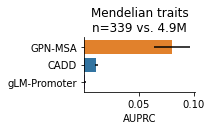

In [16]:
def format_number(num):
    """
    Converts a number into a more readable format, using K for thousands, M for millions, etc.
    Args:
    - num: The number to format.
    
    Returns:
    - A formatted string representing the number.
    """
    if num >= 1e9:
        return f'{num/1e9:.1f}B'
    elif num >= 1e6:
        return f'{num/1e6:.1f}M'
    elif num >= 1e3:
        return f'{num/1e3:.1f}K'
    else:
        return str(num)

n_pos, n_neg = V["label"].sum(), len(V) - V["label"].sum()
pos_prop = n_pos / len(V)

data = res.sort_values("AUPRC", ascending=False)
plt.figure(figsize=(2,1))
g = sns.barplot(
    data=data,
    y="model",
    x="AUPRC",
    palette=palette,
)
bar_height = g.patches[0].get_height()
y_coords = sorted([bar.get_y() + bar_height / 2 for bar in g.patches])
g.errorbar(
    x=data["AUPRC"],
    y=y_coords,
    xerr=data["se"],
    fmt='none',
    color="black",
)
g.set(
    ylabel="",
    xlim=pos_prop,
)
ss = f"n={format_number(n_pos)} vs. {format_number(n_neg)}"
d = dataset_renaming.get(dataset, dataset)
s = subset_renaming.get(subset, subset)
#plt.title(f"{d} ({s})\n{ss}")
plt.title(f"{d}\n{ss}")
sns.despine();
#plt.savefig("../../results/plots/performance_mendelian_all.pdf", bbox_inches="tight")

In [13]:
V["label"].mean()

6.854473858472302e-05